# AlexNet

## Imports

In [16]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from train import train_model
from eval import set_seed, compute_confusion_matrix
from plot import plot_training_loss, plot_accuracy, plot_confusion_matrix
from dataset_loader import get_dataloaders_cifar10, unNormalize

## Initialize Setting

In [17]:
RANDOM_SEED = 123
BATCH_SIZE  = 256
NUM_EPCOHS  = 200

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

set_seed(RANDOM_SEED)

## Applying Transforms to the Dataset

In [18]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms  = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2
)

for images, labels in train_loader:
    print('Image batch dimensions: ', images.shape)
    print('Image label dimensions: ', labels.shape)
    print('Class labels of 10 examples: ', labels[:10])
    break

Files already downloaded and verified
Image batch dimensions:  torch.Size([256, 3, 64, 64])
Image label dimensions:  torch.Size([256])
Class labels of 10 examples:  tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])


## Alex Net Architecture

In [19]:
class AleXNet(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.features = torch.nn.Sequential(

            torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),

            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),

            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),

            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),

            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256*6*6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256*6*6)

        logits = self.classifier(x)
        return logits

## Training

In [20]:
model = AleXNet(num_classes=10)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

mini_batch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPCOHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100,
    scheduler=scheduler,
    scheduler_on='valid_acc'
)

Epoch: 001/200| Batch 0000/0175| Loss: 2.3021
Epoch: 001/200| Batch 0100/0175| Loss: 2.3324
Epoch: 001/200| Train: 14.88%| Validation: 14.97%
Time elapsed: 0.44 min
Epoch: 002/200| Batch 0000/0175| Loss: 2.1617
Epoch: 002/200| Batch 0100/0175| Loss: 2.1198
Epoch: 002/200| Train: 20.09%| Validation: 20.50%
Time elapsed: 0.88 min
Epoch: 003/200| Batch 0000/0175| Loss: 1.9855
Epoch: 003/200| Batch 0100/0175| Loss: 1.8627
Epoch: 003/200| Train: 31.34%| Validation: 31.50%
Time elapsed: 1.30 min
Epoch: 004/200| Batch 0000/0175| Loss: 1.7706
Epoch: 004/200| Batch 0100/0175| Loss: 1.7621
Epoch: 004/200| Train: 43.24%| Validation: 43.28%
Time elapsed: 1.72 min
Epoch: 005/200| Batch 0000/0175| Loss: 1.6435
Epoch: 005/200| Batch 0100/0175| Loss: 1.4767
Epoch: 005/200| Train: 49.95%| Validation: 49.03%
Time elapsed: 2.14 min
Epoch: 006/200| Batch 0000/0175| Loss: 1.4705
Epoch: 006/200| Batch 0100/0175| Loss: 1.3942
Epoch: 006/200| Train: 50.08%| Validation: 51.09%
Time elapsed: 2.57 min
Epoch: 007

## Plots

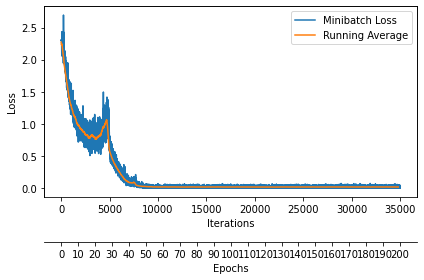

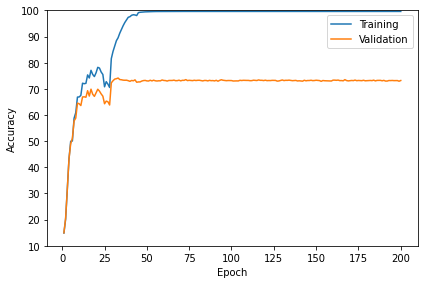

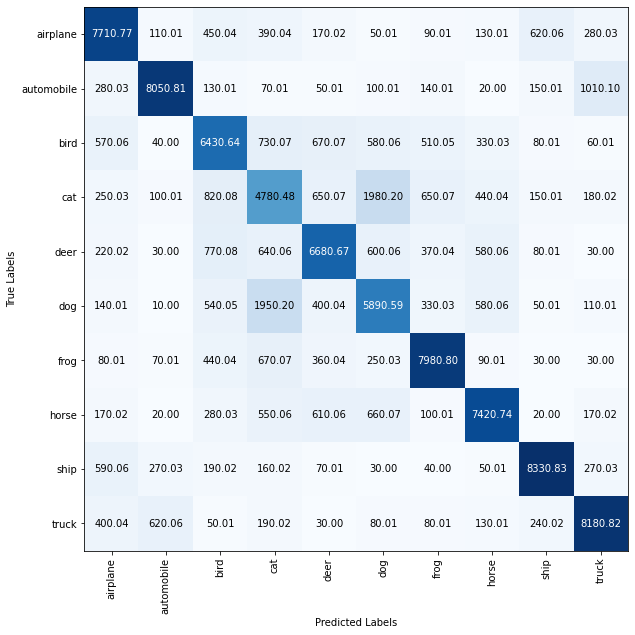

In [22]:
plot_training_loss(mini_batch_loss_list=mini_batch_loss_list,
                   num_epoch=NUM_EPCOHS,
                   iter_per_epoch=len(train_loader),
                   result_dir=None,
                   averaging_iteration=200
                   )

plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None
)
plt.ylim([10, 100])
plt.show()

model.cpu()
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, figsize=(10, 10), show_absolute=True, class_names=class_dict.values())
plt.show()